## Quantum Compiler

*Dmytro Fedoriaka, January 2026*

### Problem statement

Given mathematical expression (consisting of variables, real-valued literals and
functions), build quantum circuit computing this expression.

For each variable in expression you are told which QFixed register holds value of this variable.
After you have built a circuit, you need to tell in which register ths answer is located.

### API

Create Qubrick called EvaluateExpression that takes expression to evaluate as string in constructor.
Pass name-to-expression map in `compute`. Can pass QFixed registers or literals.

```
compiler = EvaluateExpression("x*x + z*y", qc=qpu)
compiler.compute({"x": qs_x, "y": qs_y, "z": 5})
```

### High-level design

* Parse expresison using `ast.parse` from Python standard library.
* Optimize expression. Rules that transform AST. We could define our own AST model, 
  but I think using Python's modle is fine.
* Build circuit butom-up: 
  * Traverse AST using DFS.   
  * For every node, produce `QValue = QFixed | float` that is literal or register with result of computing that node.
  * For variables, do lookup.
  * For literals, return them.
  * For ops/function, call correspodning Qubrick.
  * If funcion is out-of-place, allocate register before calling function.
  * If function is in-place but we cannot modify args, allocate register, copy one arg there and call the function.
  * Otherwise if it's in-place function, just call corresponding Qubrick without allocations.

### Demo

Currently implemented prototype in [evaluate.py](../qmath/compile/evaluate.py) supports
addition, subtraction and multiplication and doesn't have optimizers.


In [20]:
from psiqworkbench import QPU, QFixed
from psiqworkbench.filter_presets import BIT_DEFAULT

from qmath.compile import EvaluateExpression

qpu = QPU(filters=BIT_DEFAULT)
qpu.reset(150)
qs_x = QFixed(20, name="x", radix=5, qpu=qpu)
qs_y = QFixed(20, name="y", radix=5, qpu=qpu) 
x, y = -10, 8
qs_x.write(x)
qs_y.write(y) 

compiler = EvaluateExpression("x*x + z*y", qc=qpu)
compiler.compute({"x": qs_x, "y": qs_y, "z": 5})
ans = compiler.get_result_qreg()
print("Result:", ans.read())


Result: 140.0


In [15]:
qpu.draw()

### Mutable/immutable inputs.

By default all input variables are immutable - circuit will not change their value.
But if you pass variable name in `mutable_vars`, you will allow compiler
to mutate value and maybe use input as output.

Example below shows 2 circuits for the same expression x+y, where in first case
we make a copy of x and add y to it, while in second case we comput the sum in place.


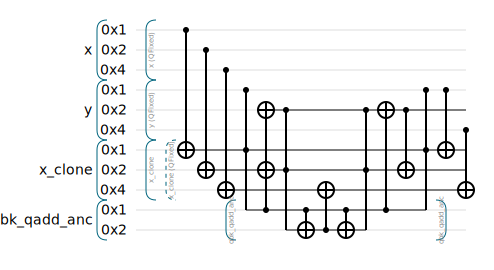

In [18]:
qpu = QPU(filters=BIT_DEFAULT)
qpu.reset(11)
qs_x = QFixed(3, name="x", radix=0, qpu=qpu)
qs_y = QFixed(3, name="y", radix=0, qpu=qpu) 
compiler = EvaluateExpression("x+y", qc=qpu).compute({"x": qs_x, "y": qs_y})
qpu.draw()

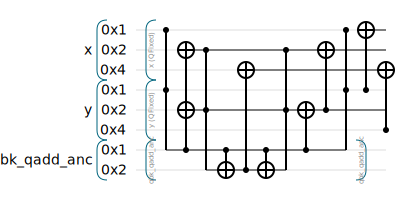

In [17]:
qpu = QPU(filters=BIT_DEFAULT)
qpu.reset(8)
qs_x = QFixed(3, name="x", radix=0, qpu=qpu)
qs_y = QFixed(3, name="y", radix=0, qpu=qpu) 
compiler = EvaluateExpression("x+y", mutable_vars=["x"], qc=qpu).compute({"x": qs_x, "y": qs_y})
qpu.draw()


### Further work

* **Add more functions**.
  * Quantum-constant division - reduce to multiplication.
  * Constant-quantum division - reduce to inverse+multiplication, or to quantum-quantum division (which is better?).
  * Quantum-Quantum division - extend integer alorithms.
  * Integer power - handle at optimizer level, use binary exponetiation and Square function.
  * Trigonometry, logarithms, exponent etc. - need to implement the functions first + build framework for accuracy propagation.
  * Maybe integrate piecewise polynomial approximation, but then it will work only on fixed interval.

* **Implement optimizer**. Implement rule-based optimizer that would transform AST
by matching patterns and replacing them with other patterns. Some rules can be 
bottom-up simngle pass, some will be fixed point (e.g. Horner Scheme).

* **Implement optimizer rules**. Below are some ideas
  * Common subexpressions. E.g. if expression (2*x+y) appears 2+ times,
      allocate temporary register t, compute t:=2*x+y, and replace 2*x+y with t 
      in AST. For this we will have to extend AST to have "Assignment" node. 
  * Constant folding.
  * Binary exponentiation, e.g. x**4 -> Square(Square(x)).
  * Horner scheme optimizer, e.g. a*x^3 + b *x^2 + x* c -> x * (a*x ^2 + b*x + c).

* **Accuracy**. You give desired accuracy of the answer, and compiler automaticlaly computes
size of intermediary registers and answer to achieve this accuracy. It is possible that we would need higher radix
in intermediary computations to achieve desired accuracy.
Doing this right will be quite hard. We will have to propagate error stop-down from root to nodes, and for each
function we will have a formula - if this is required accuracy of output, what is required accuracy of input.
This will be used to compute size and radix for intermediary allocated regsiters.